In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

### Input Images

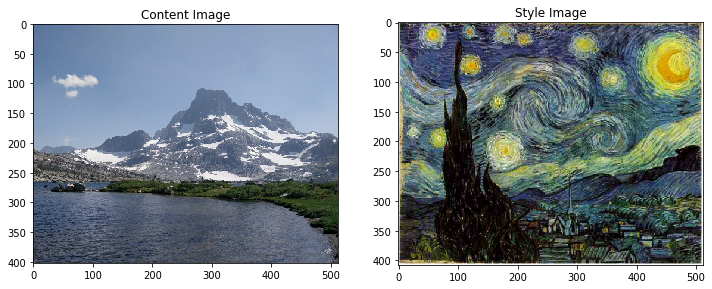

In [6]:
# Content image
content_image = load_img('landscape.jpg')
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

# Style image
style_image = load_img('starry_night.jpg')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

plt.show()

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
#content_layers = ['block5_conv2'] 
content_layers = ['block5_conv4']

#style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [11]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name, type(output))
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1 <class 'tensorflow.python.framework.ops.EagerTensor'>
  shape:  (1, 408, 512, 64)
  min:  0.0
  max:  876.13245
  mean:  25.167658

block2_conv1 <class 'tensorflow.python.framework.ops.EagerTensor'>
  shape:  (1, 204, 256, 128)
  min:  0.0
  max:  4031.3032
  mean:  156.27911

block3_conv1 <class 'tensorflow.python.framework.ops.EagerTensor'>
  shape:  (1, 102, 128, 256)
  min:  0.0
  max:  12776.816
  mean:  150.57068

block4_conv1 <class 'tensorflow.python.framework.ops.EagerTensor'>
  shape:  (1, 51, 64, 512)
  min:  0.0
  max:  27041.16
  mean:  610.1858



In [12]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [14]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0013207056
    max:  17359.25
    mean:  439.5414

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  99026.836
    mean:  10975.785

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  158756.02
    mean:  8495.674

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2406800.8
    mean:  132935.0

Contents:
   block5_conv4
    shape:  (1, 25, 32, 512)
    min:  0.0
    max:  132.8929
    mean:  0.3097749


In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
image = tf.Variable(content_image)

In [17]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [19]:
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

In [20]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [21]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    print(grad)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Tensor("AddN_5:0", shape=(1, 403, 512, 3), dtype=float32)
Tensor("AddN_5:0", shape=(1, 403, 512, 3), dtype=float32)


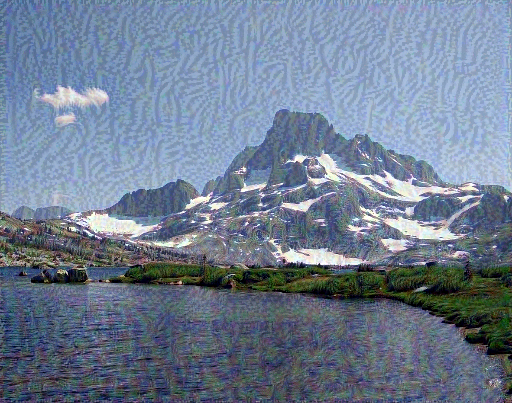

In [22]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [23]:
def train(content_layers, style_layers, epochs=10, steps_per_epoch=100):
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)
    
    extractor = StyleContentModel(style_layers, content_layers)
    
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    
    # Start training
    import time
    start = time.time()

    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(".", end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end-start))

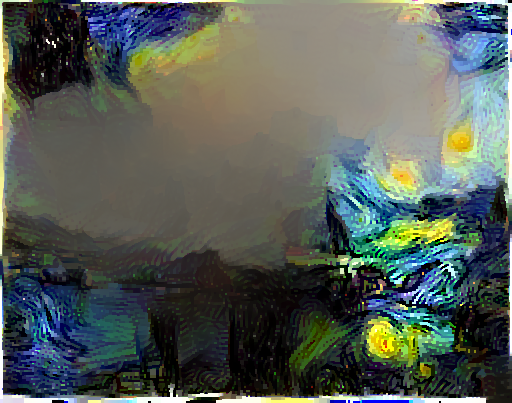

Train step: 350
......................

In [ ]:
POSSIBLE_CONTENT_LAYERS = ['block5_conv' + str(x) for x in range(2, 5)]
POSSIBLE_STYLE_LAYERS = ['block' + str(x) + '_conv1' for x in range(1, 5)]
print(POSSIBLE_CONTENT_LAYERS)
print(POSSIBLE_STYLE_LAYERS)

import itertools
CONTENT_LAYER_POOL = []
for i in range(len(POSSIBLE_CONTENT_LAYERS)):
    CONTENT_LAYER_POOL += list(itertools.combinations(POSSIBLE_CONTENT_LAYERS, i + 1))

STYLE_LAYER_POOL = []
for i in range(len(POSSIBLE_STYLE_LAYERS)):
    STYLE_LAYER_POOL += list(itertools.combinations(POSSIBLE_STYLE_LAYERS, i + 1))

for i in range(len(CONTENT_LAYER_POOL)):
    for j in range(len(STYLE_LAYER_POOL)):
        train(CONTENT_LAYER_POOL[i], STYLE_LAYER_POOL[j], epochs=10, steps_per_epoch=50)
        file_name = 'output-content-' + '-'.join(CONTENT_LAYER_POOL[i]) + '-style-' + '-'.join(STYLE_LAYER_POOL[j])
        tensor_to_image(image).save(file_name + '.jpg')

In [ ]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

In [ ]:
tf.image.total_variation(image).numpy()